# Proyecto #3 Exploración y Creación de Características
### Branch: daniel-tarea3

### Librerias

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from feature_engine.outliers import Winsorizer

## a) Carga de dataset

In [5]:
DATA_DIR = Path("../data/raw")
train = pd.read_csv(DATA_DIR / "train.csv")
stores = pd.read_csv(DATA_DIR / "stores.csv")
train.head(), stores.head(), train.shape, stores.shape

(   id        date  store_nbr      family  sales  onpromotion
 0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
 1   1  2013-01-01          1   BABY CARE    0.0            0
 2   2  2013-01-01          1      BEAUTY    0.0            0
 3   3  2013-01-01          1   BEVERAGES    0.0            0
 4   4  2013-01-01          1       BOOKS    0.0            0,
    store_nbr           city                           state type  cluster
 0          1          Quito                       Pichincha    D       13
 1          2          Quito                       Pichincha    D       13
 2          3          Quito                       Pichincha    D        8
 3          4          Quito                       Pichincha    D        9
 4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4,
 (3000888, 6),
 (54, 5))

In [8]:
# convertir fecha
train['date'] = pd.to_datetime(train['date'])

# ordenar por fecha
train = train.sort_values('date')

# merge con info de tienda
df = train.merge(stores, on='store_nbr', how='left')

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 228.9+ MB


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2
3,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2


# b) Ingeniería de Características

### Generación de valores Nulos

In [9]:
# copia de dataframe
df_features = df.copy()
np.random.seed(42)

# columnas para forzar NaN
cat_cols = ['city', 'state', 'type', 'family']
num_cols = ['onpromotion', 'cluster']

# ~2% de NaN en categóricas
for col in cat_cols:
    idx = df_features.sample(frac=0.02, random_state=(hash(col) % (2**32))).index
    df_features.loc[idx, col] = np.nan

# ~2% de NaN en numéricas
for col in num_cols:
    idx = df_features.sample(frac=0.02, random_state=((hash(col)+1) % (2**32))).index
    df_features.loc[idx, col] = np.nan

# outliers en sales: 0.1% de filas con multiplicador x5 
idx_out = df_features[df_features['sales'] > 0].sample(frac=0.001, random_state=123).index
df_features.loc[idx_out, 'sales'] = df_features.loc[idx_out, 'sales'] * 5


In [16]:
# % de NaN por columna
nan_rates = df_features[cat_cols + num_cols].isna().mean().round(4)
nan_rates, df['sales'].quantile(0.99), df_features['sales'].quantile(0.99)


(city           0.02
 state          0.02
 type           0.02
 family         0.02
 onpromotion    0.02
 cluster        0.02
 dtype: float64,
 np.float64(5507.0),
 np.float64(5526.0))

In [17]:
#Verificación de nulos
print()
df_features.isna().sum().sort_values(ascending=False)

onpromotion    60018
family         60018
type           60018
cluster        60018
state          60018
city           60018
date               0
id                 0
sales              0
store_nbr          0
dtype: int64

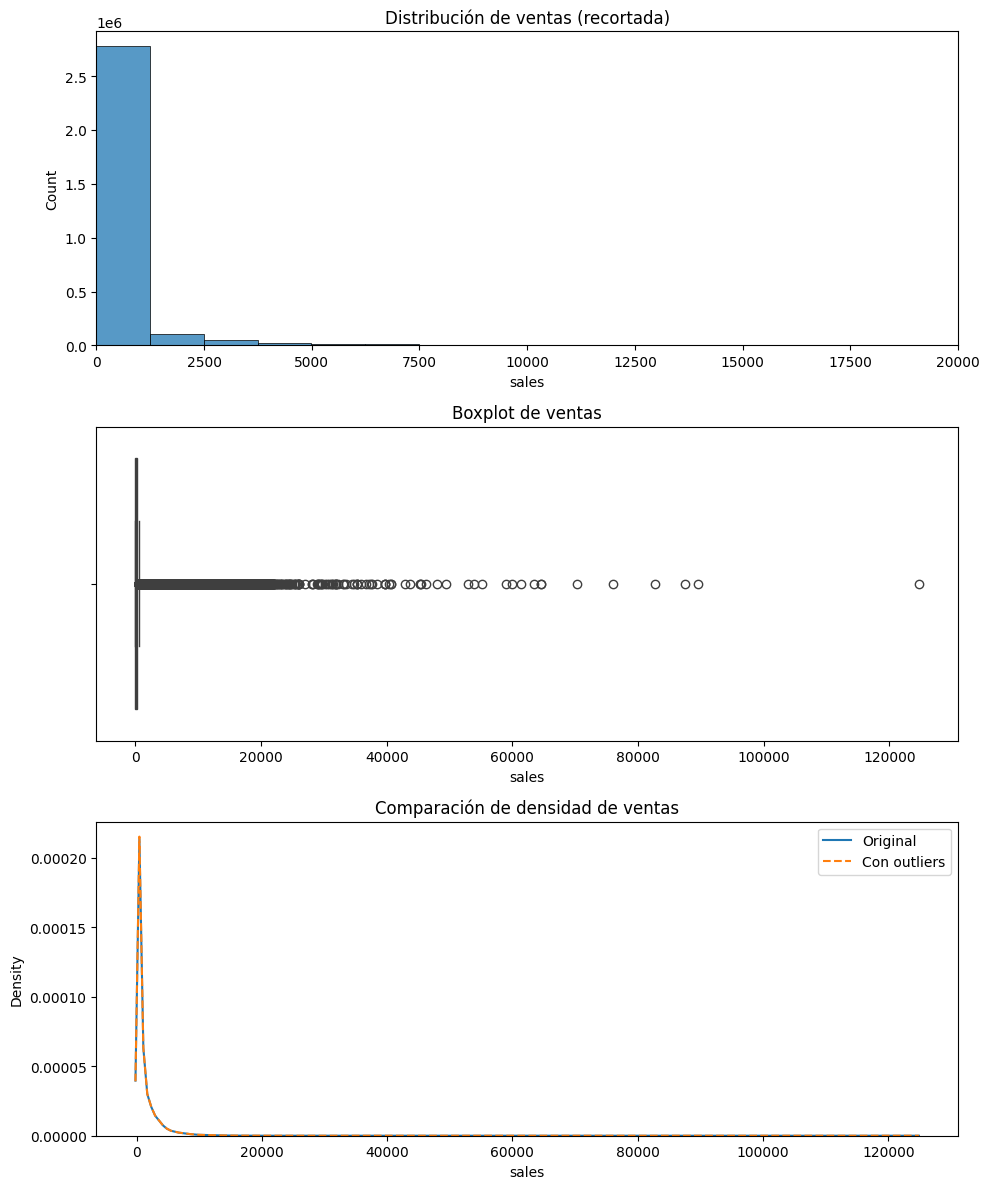

In [14]:
# Visualizando
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Histograma
sns.histplot(df_features['sales'], bins=100, ax=axes[0])
axes[0].set_xlim(0, 20000)
axes[0].set_title('Distribución de ventas (recortada)')

# Boxplot
sns.boxplot(x=df_features['sales'], ax=axes[1])
axes[1].set_title('Boxplot de ventas')

# Densidad comparativa
sns.kdeplot(df['sales'], label='Original', ax=axes[2])
sns.kdeplot(df_features['sales'], label='Con outliers', linestyle='--', ax=axes[2])
axes[2].legend()
axes[2].set_title('Comparación de densidad de ventas')

plt.tight_layout()
plt.show()


### b.i Imputación de variables numéricas.

In [19]:
# Imputación con mediana
num_imp = SimpleImputer(strategy='median')
df_features[num_cols] = num_imp.fit_transform(df_features[num_cols])

# devolver a entero
df_features['onpromotion'] = df_features['onpromotion'].round().astype('int64')
df_features['cluster']     = df_features['cluster'].round().astype('int64')

print("Nulos después de imputación numérica:")
df_features[num_cols].isna().sum()

Nulos después de imputación numérica:


onpromotion    0
cluster        0
dtype: int64

### b.ii Imputación de variables categóricas

In [20]:
# imputar NaN con la categoría más frecuente o “moda”
cat_imputer = SimpleImputer(strategy='most_frequent')

# imputación
df_features[cat_cols] = cat_imputer.fit_transform(df_features[cat_cols])

# Verificamos que no queden valores faltantes
print("Nulos después de imputación categórica:")
print(df_features[cat_cols].isna().sum())

Nulos después de imputación categórica:
city      0
state     0
type      0
family    0
dtype: int64


### b.iii Codificación de variables categóricas.

In [21]:
# Columnas categóricas
ordinal_cols = ['city', 'state', 'type']
onehot_col = ['family']

# Codificación ordinal
ord_enc = OrdinalEncoder()
df_features[ordinal_cols] = ord_enc.fit_transform(df_features[ordinal_cols])

# one-hot encoding (columnas binarias por categoría)
onehot_enc = OneHotEncoder(sparse_output=False, drop='first')  # evita multicolinealidad
family_encoded = onehot_enc.fit_transform(df_features[onehot_col])

# Convertir el resultado a DataFrame
family_encoded_df = pd.DataFrame(
    family_encoded,
    columns=onehot_enc.get_feature_names_out(onehot_col)
)

# Combinar con el dataset original y eliminar la columna original
df_features = pd.concat([df_features.drop(columns=onehot_col), family_encoded_df], axis=1)

In [22]:
# Verificar el resultado
print("Dimensiones después de codificación:", df_features.shape)
print("Primeras columnas después de codificación:")
df_features.head()

Dimensiones después de codificación: (3000888, 41)
Primeras columnas después de codificación:


,id,date,store_nbr,sales,onpromotion,city,state,type,cluster,family_BABY CARE,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,0,2013-01-01,1,0.0,0,18.0,12.0,3.0,13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1194,2013-01-01,42,0.0,0,3.0,0.0,3.0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1193,2013-01-01,42,0.0,0,3.0,0.0,3.0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1192,2013-01-01,42,0.0,0,3.0,0.0,3.0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1191,2013-01-01,42,0.0,0,3.0,0.0,3.0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### b.iv Tratamiento de outliers

In [23]:
# límites percentiles 1% y 99%
q_low = df_features['sales'].quantile(0.01)
q_high = df_features['sales'].quantile(0.99)

# Reemplazar valores fuera de rango por los límites
df_features['sales'] = np.where(df_features['sales'] < q_low, q_low, df_features['sales'])
df_features['sales'] = np.where(df_features['sales'] > q_high, q_high, df_features['sales'])


In [25]:
# Verificar rango
print("Rango de ventas después de winsorización:")
print("Mínimo:", df_features['sales'].min())
print("Máximo:", df_features['sales'].max())

Rango de ventas después de winsorización:
Mínimo: 0.0
Máximo: 5526.0


### b.v Transformación de variables numéricas.

In [ ]:
# Copia para comparar antes/después
sales_before = df_features['sales'].copy()

# Yeo-Johnson en 'sales' (continua y con ceros)
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_features['sales'] = pt.fit_transform(df_features[['sales']])

In [27]:
# validar cambio en asimetría
print("Skew antes:", sales_before.skew())
print("Skew después:", df_features['sales'].skew())


Skew antes: 4.0502049982863175
Skew después: 0.14147517236259716


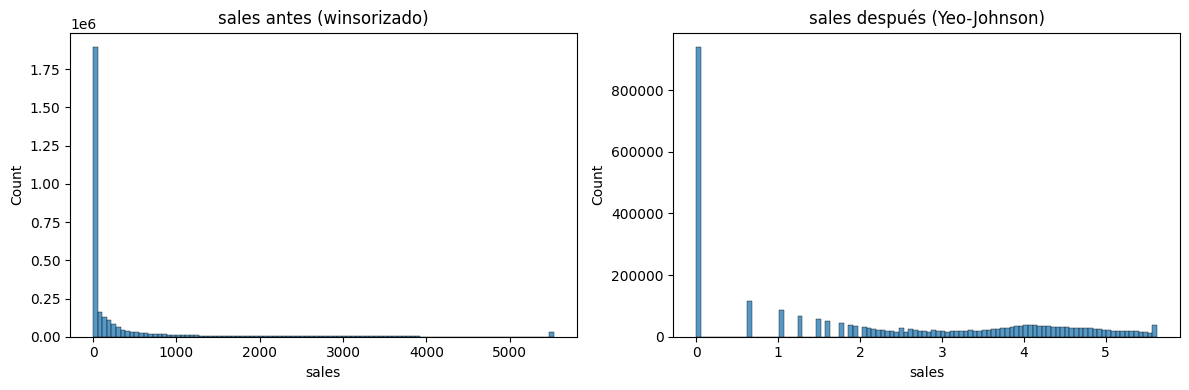

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(sales_before, bins=100, ax=axes[0])
axes[0].set_title('sales antes (winsorizado)')
sns.histplot(df_features['sales'], bins=100, ax=axes[1])
axes[1].set_title('sales después (Yeo-Johnson)')
plt.tight_layout(); plt.show()


### b.vi Escalado de características

In [29]:
# Columnas numéricas a escalar
num_cols_to_scale = ['sales', 'onpromotion', 'cluster']

# Crear el escalador
scaler = StandardScaler()

# Ajustar y transformar
df_features[num_cols_to_scale] = scaler.fit_transform(df_features[num_cols_to_scale])


In [30]:
# Verificar resultado
df_features[num_cols_to_scale].describe().T

,count,mean,std,min,25%,50%,75%,max
sales,3000888.0,1.794205e-16,1.0,-1.169174,-1.169174,-0.027886,0.941684,1.775138
onpromotion,3000888.0,1.621831e-16,1.0,-0.210631,-0.210631,-0.210631,-0.210631,60.990097
cluster,3000888.0,2.071330e-17,1.0,-1.627408,-0.975751,0.110344,0.979220,1.848096


### Guardar data procesada

In [32]:
df_features.to_csv('../data/processed/feature_engineered.csv', index=False)


# c) Concluciones

**Procesos aplicados:**

Imputación numérica: se aplicó a las columnas onpromotion y cluster utilizando la mediana para reemplazar valores nulos.

Imputación categórica: se imputaron las columnas city, state, type y family usando la categoría más frecuente (moda).

Tratamiento de outliers: se generaron valores extremos y se aplicó una winsorización del 0.5% para reducir su influencia.

Transformación numérica: se aplicó la transformación Yeo-Johnson sobre la variable sales para reducir la asimetría en su distribución (skew de 4.05 a 0.14).

Escalado: se utilizó StandardScaler sobre sales para normalizar la escala de la variable y facilitar el entrenamiento de modelos posteriores.

**Variables finales en el dataset procesado:**

Variables numéricas: sales, onpromotion, cluster

Variables categóricas: city, state, type, family

Variable temporal: date

Identificador: id

**Mecanismos de mapeo y reproducibilidad:**

Todas las transformaciones se aplicaron sobre df_features en el notebook 02_feature_exploration.ipynb.

El resultado final se guarda como data/processed/feature_engineered.csv.

Si el archivo no existe, el notebook lo regenerará automáticamente al ser ejecutado.

Los parámetros aplicados (mediana, moda, winsorización 0.5%, Yeo-Johnson y StandardScaler) pueden modificarse si se requiere ajustar el proceso.